In [ ]:
from google.colab import drive
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
drive.mount('/content/drive', force_remount=True)

# FOLDERNAME = 'repo'
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
sys.path.append('/content/drive/My Drive/repo/codes')
from utils import video_utils

Mounted at /content/drive


In [ ]:
STRING_BODY = 'frame_{}.jpeg'
IMAGE_PATH = '/content/drive/My Drive/repo/dataFrame/all_frames'
DATA_FRAME_PATH = '/content/drive/My Drive/repo/dataFrame'
NEW_PATH = '/content/drive/My Drive/repo/dataFrame/frames_s_100/'

In [ ]:
image1 = cv2.imread(NEW_PATH +'frame_0001.jpeg')
image2 = cv2.imread(NEW_PATH + 'frame_0075.jpeg')
image3 = cv2.imread(NEW_PATH + 'frame_0148.jpeg')
image4 = cv2.imread(NEW_PATH + 'frame_0222.jpeg')

In [ ]:
def cumulative_sum (data_frame_path, image_path, translation = 100):
  df = pd.read_csv(data_frame_path)
  x = df['x']
  y = df['y']
  c = df['c']

  frame = np.array(Image.open(image_path + '/frame_0001.jpeg'))
  translation = frame.shape[0] - 100

  counter = 0
  aux = 0
  while aux < translation:
    if (abs(df['y'][counter]) > abs(df['x'][counter])):
      aux += abs(df['y'][counter])
    counter += 1
  return aux, counter

In [ ]:
df = pd.read_csv(DATA_FRAME_PATH + '/phase_correlation.csv')
x = df['x']
y = df['y']
c = df['c']
frame = np.array(Image.open(IMAGE_PATH + '/frame_0001.jpeg'))
translation = frame.shape[0] - 100

pixel_overlap = []
images_num = [1]
counter = 0
for i in range(86):
  aux = 0
  while aux < translation:
    if (abs(df['y'][counter]) > abs(df['x'][counter])):
      aux += abs(df['y'][counter])
    counter += 1
  pixel_overlap.append(frame.shape[0] - aux)
  overlap_df = pd.DataFrame(pixel_overlap)
  overlap_df.columns = ['sobreposicao']
  images_num.append(counter)


In [ ]:
overlap1 = int(overlap_df['sobreposicao'][0])
overlap2 = int(overlap_df['sobreposicao'][1])
overlap3 = int(overlap_df['sobreposicao'][2])

In [ ]:
def concatenate_images_vertical(image1, image2):
    # Obter as larguras das duas imagens
    width1, width2 = image1.shape[1], image2.shape[1]

    # Verificar qual das duas imagens é mais larga e ajustar a outra imagem para a mesma largura
    if width1 < width2:
        image1 = cv2.resize(image1, (width2, int(image1.shape[0] * width2 / width1)))
    elif width2 < width1:
        image2 = cv2.resize(image2, (width1, int(image2.shape[0] * width1 / width2)))

    # Concatenar as duas imagens verticalmente
    concatenated_image = np.vstack((image1, image2))

    return concatenated_image

In [ ]:
def convolve_with_sine_kernel(image, side = 'up', translation = 100):

  rows, columns, channel = image.shape

  if side == 'up':
    for_condition = [range(channel), range(0, translation), range(columns)]
    x = np.linspace(0, np.pi/2, translation)
    mask = np.sin(x)**2
  elif side == 'low':
    for_condition = [range(channel), range(rows - translation, rows), range(columns)]
    x = np.linspace(np.pi/2, np.pi, translation)
    mask = np.sin(x)**2
  elif side == 'left':
    for_condition = [range(channel), range(rows), range(0, translation)]
    x = np.linspace(0, np.pi/2, translation)
    mask = np.sin(x)**2
  elif side == 'right':
    for_condition = [range(channel), range(rows), range(columns - translation, columns)]
    x = np.linspace(np.pi/2, np.pi, translation)
    mask = np.sin(x)**2
  else:
    return False

  x = np.linspace(0, np.pi, image1.shape[0])
  y = np.sin(x)**2

  convolved_image = np.copy(image)

  for k in for_condition[0]:
    for i in for_condition[1]:
      for j in for_condition[2]:
        if side == 'up':
          convolved_image[i][j][k] = convolved_image[i][j][k]*mask[i]
        elif side == 'low':
          convolved_image[i][j][k] = convolved_image[i][j][k]*mask[i - rows + translation]
        elif side == 'right':
          convolved_image[i][j][k] = convolved_image[i][j][k]*mask[j - columns + translation]
        elif side == 'left':
          convolved_image[i][j][k] = convolved_image[i][j][k]*mask[j]


  return convolved_image

In [ ]:
def truncate_images(image1, image2, axis = 'vertical', translation = 100):

  rows1, columns1, channel1 = image1.shape
  rows2, columns2, channel2 = image2.shape

  if axis == 'vertical':
    # image2 acima da image1
    truncate_image = np.vstack((image2[:rows2 - translation], image1))
    truncate_image[rows2 - translation: rows2] = image1[0:translation] + image2[rows2-translation:rows2]
    #################
    ## NOT WORKING ##
    #################
  elif axis == 'horizontal':
    # image2 à direita da image1
    truncate_image = np.hstack((image1[:][:columns1 - translation], image2))
    for i in range(rows1):
      truncate_image[i][columns1-translation: columns1] = image1[i][columns1-translation:] + image2[i][0:translation]
  else:
    return 1

  return truncate_image

In [ ]:
new_image1 = convolve_with_sine_kernel(image1, 'up', overlap1*3)
new_image2 = convolve_with_sine_kernel(image2,'low', overlap1*3)
new_image2 = convolve_with_sine_kernel(new_image2, 'up', overlap2*3)
new_image3 = convolve_with_sine_kernel(image3, 'low', overlap2*3)
new_image3 = convolve_with_sine_kernel(new_image3, 'up', overlap3*3)
new_image4 = convolve_with_sine_kernel(image4, 'low', overlap3*3)

In [ ]:
concat_image1 = truncate_images(new_image1, new_image2, 'vertical', overlap1*3)
concat_image2 = truncate_images(concat_image1, new_image3, 'vertical', overlap2*3)
concat_image3 = truncate_images(concat_image2, new_image4, 'vertical', overlap3*3)

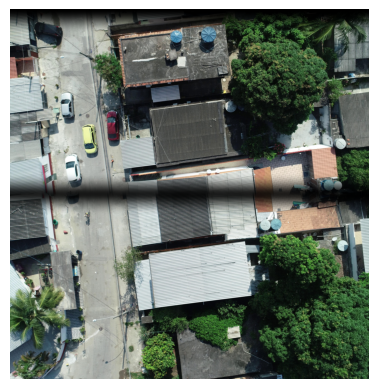

In [ ]:
truncate_image = truncate_images(new_image1, new_image2, 'vertical', int(overlap_df['sobreposicao'][0]))
plt.imshow(cv2.cvtColor(truncate_image,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Imagens

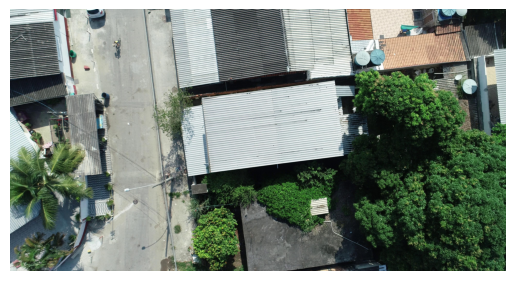

In [ ]:
plt.imshow(cv2.cvtColor(image1,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Imagens concatenadas

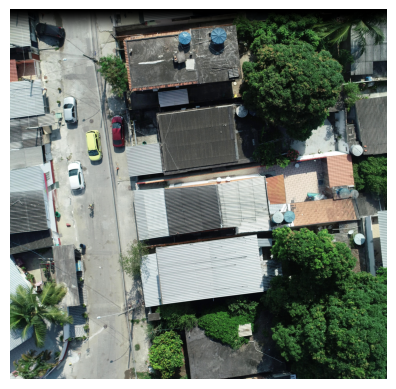

In [ ]:
plt.imshow(cv2.cvtColor(concat_image1,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

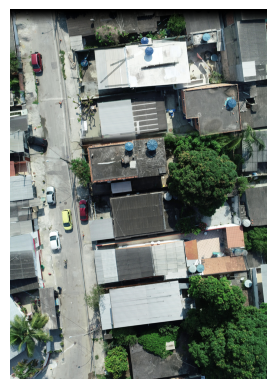

In [ ]:
plt.imshow(cv2.cvtColor(concat_image2,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

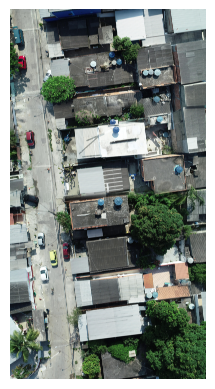

In [ ]:
plt.imshow(cv2.cvtColor(concat_image3,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# TESTES

In [ ]:
def concatenate_images(image1, image2):
    # Obter as alturas das duas imagens
    height1, height2 = image1.shape[0], image2.shape[0]

    # Verificar qual das duas imagens é mais alta e ajustar a outra imagem para a mesma altura
    if height1 < height2:
        image1 = cv2.resize(image1, (int(image1.shape[1] * height2 / height1), height2))
    elif height2 < height1:
        image2 = cv2.resize(image2, (int(image2.shape[1] * height1 / height2), height1))

    # Concatenar as duas imagens lado a lado
    concatenated_image = np.hstack((image1, image2))

    return concatenated_image

In [ ]:
def truncate_images(image1, image2, axis = 'vertical', translation = 100):

  rows1, columns1, channel1 = image1.shape
  rows2, columns2, channel2 = image2.shape

  if axis == 'vertical':
    # image2 acima da image1
    truncate_image = np.vstack((image2[:rows2 - translation], image1))
    truncate_image[rows2 - translation: rows2] = image1[0:translation] + image2[rows2-translation:rows2]
    #################
    ## NOT WORKING ##
    #################
  elif axis == 'horizontal':
    # image2 à direita da image1
    truncate_image = np.hstack((image1[:][:columns1 - translation], image2))
    for i in range(rows1):
      truncate_image[i][columns1-translation: columns1] = image1[i][columns1-translation:] + image2[i][0:translation]
  else:
    return 1

  return truncate_image

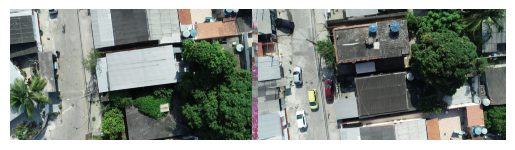

In [ ]:
# aux_image = concatenate_images(image1, image2)
aux_image = truncate_images(image1, image2, 'horizontal')
plt.imshow(cv2.cvtColor(aux_image,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Salvando imagens

In [ ]:
image  = Image.fromarray(cv2.cvtColor(image1,cv2.COLOR_BGR2RGB))
image.save('imagem1.jpeg','JPEG')

image  = Image.fromarray(cv2.cvtColor(image2,cv2.COLOR_BGR2RGB))
image.save('imagem2.jpeg','JPEG')

image = Image.fromarray(cv2.cvtColor(image3,cv2.COLOR_BGR2RGB))
image.save('imagem3.jpeg','JPEG')

image  = Image.fromarray(cv2.cvtColor(image4,cv2.COLOR_BGR2RGB))
image.save('imagem4.jpeg','JPEG')

image = Image.fromarray(cv2.cvtColor(concat_image1,cv2.COLOR_BGR2RGB))
image.save('imagem_concatenada1.jpeg','JPEG')

image  = Image.fromarray(cv2.cvtColor(concat_image2,cv2.COLOR_BGR2RGB))
image.save('imagem_concatenada2.jpeg','JPEG')

image  = Image.fromarray(cv2.cvtColor(concat_image3,cv2.COLOR_BGR2RGB))
image.save('imagem_concatenada3.jpeg','JPEG')

In [ ]:
!zip frames_new.zip imagem1.jpeg imagem2.jpeg imagem3.jpeg imagem4.jpeg imagem_concatenada1.jpeg imagem_concatenada2.jpeg imagem_concatenada3.jpeg

  adding: imagem1.jpeg (deflated 0%)
  adding: imagem2.jpeg (deflated 0%)
  adding: imagem3.jpeg (deflated 0%)
  adding: imagem4.jpeg (deflated 0%)
  adding: imagem_concatenada1.jpeg (deflated 0%)
  adding: imagem_concatenada2.jpeg (deflated 0%)
  adding: imagem_concatenada3.jpeg (deflated 0%)
